In [1]:
from util.backtest import *
from util.factor_util import *
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools
from tqdm import tqdm
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] =False

INSAMPLE_END = datetime(2021,7,1)
VALD_END = datetime(2022,6,1)

url = 'https://api.tardis.dev/v1/exchanges/binance-futures'
result = requests.get(url).json()
remove_date = {sym['id']:pd.to_datetime(sym['availableTo']) for sym in result['availableSymbols'] if 'availableTo' in sym.keys() and sym['type']=='perpetual'}
remove_date



{'tlmbusd': Timestamp('2023-04-05 00:00:00+0000', tz='UTC'),
 'leverbusd': Timestamp('2023-04-05 00:00:00+0000', tz='UTC'),
 'ambbusd': Timestamp('2023-04-05 00:00:00+0000', tz='UTC'),
 'luna2busd': Timestamp('2023-03-23 00:00:00+0000', tz='UTC'),
 'icpbusd': Timestamp('2023-03-23 00:00:00+0000', tz='UTC'),
 'hntusdt': Timestamp('2023-03-21 00:00:00+0000', tz='UTC'),
 'galbusd': Timestamp('2023-03-16 00:00:00+0000', tz='UTC'),
 'wavesbusd': Timestamp('2023-03-16 00:00:00+0000', tz='UTC'),
 'cvxbusd': Timestamp('2023-03-16 00:00:00+0000', tz='UTC'),
 'ancbusd': Timestamp('2022-12-16 00:00:00+0000', tz='UTC'),
 'auctionbusd': Timestamp('2022-12-16 00:00:00+0000', tz='UTC'),
 'cvcusdt': Timestamp('2022-11-30 00:00:00+0000', tz='UTC'),
 'srmusdt': Timestamp('2022-11-16 00:00:00+0000', tz='UTC'),
 'rayusdt': Timestamp('2022-11-16 00:00:00+0000', tz='UTC'),
 'fttbusd': Timestamp('2022-11-15 00:00:00+0000', tz='UTC'),
 'fttusdt': Timestamp('2022-11-15 00:00:00+0000', tz='UTC'),
 'btsusdt': Ti

In [2]:
INSAMPLE_END_DATE = datetime(2021,7,1)
VALID_END_DATE = datetime(2022,6,1)
SAMPLE_END_DATE = datetime(2022,8,31)

FREQ = 'D'


df = pd.read_csv('/home/frank/document/Python/Factors/data/data_1h.csv')
df['BuyerRatio'] = df['takerBuyQuoteVol']/df['quoteAssetVolume']
df['BuyerPerTrade'] = df['takerBuyQuoteVol']/df['numberOfTrades']
df['VolumePerTrade'] = df['quoteAssetVolume']/df['numberOfTrades']

df = df.drop(['Volume','numberOfTrades'],axis= 1)
print('Dataframe prepared completed')

categories = {}
with open('/home/frank/document/Python/Factors/data/Crytpo_categories.json','r') as f:
    categories = json.loads(f.read())    
categories['all'] = df.symbol.unique()

col_list = ['Open','High','Low','Close','quoteAssetVolume','takerBuyQuoteVol','BuyerRatio']
df_data = {}
for col in col_list:
    df_data[col] = df.pivot(values = col,index = 'openTime',columns = 'symbol').astype(float)
    df_data[col].index = pd.to_datetime(df_data[col].index,unit = 'ms') #+ timedelta(hours=8)

print("Pivot table completed")

Dataframe prepared completed
Pivot table completed


In [3]:
metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/level1_IC_metrics.csv',index_col = 0)
# metrics = pd.read_csv('/home/frank/document/Python/Factors/output/backtest_result/D/backtest_metrics_20230221.csv',index_col = 0)
print(metrics.shape)
metrics = metrics.sort_index().drop_duplicates('Sharpe').sort_values('Fitnessvalue',ascending = False)
metrics = metrics[metrics['Insample Sharpe']*0.5< metrics['Outsample Sharpe']]
metrics = metrics[metrics['Sharpe'] != metrics['Fitnessvalue']]
metrics = metrics[metrics['Sharpe'] >=1]
# metrics = metrics[(metrics['Long Fitness'] >= 0) & (metrics['Short Fitness'] >= 0)]

print(metrics.shape)
# print(metrics.sort_values('Fitnessvalue',ascending = False).index[:20])
metrics.sort_values('Fitnessvalue',ascending = False).head()#.shape


(73212, 25)
(5013, 25)


,Sharpe,Fitnessvalue,turnover,IC,IR,Rank_IC,Rank_IR,Insample Sharpe,Outsample Sharpe,Long Fitness,...,IS_turnover,OS_turnover,IS_IC,IS_IR,OS_IC,OS_IR,IS_Rank_IC,IS_Rank_IR,OS_Rank_IC,OS_Rank_IR
Strategy,,,,,,,,,,,,,,,,,,,,,
Low/Close.SignedPower.SignedPower.Skew,3.534968,1.887994,6.413433,0.027664,0.194303,0.013158,0.114667,1.525334,3.336580,0.421519,...,6.614119,6.320157,0.025085,0.206114,0.028286,0.232769,0.011143,0.095588,0.014295,0.118854
BuyerRatio*Low/Close.Skew.Mean.Skew,3.961539,1.710665,9.246631,0.006984,0.076467,0.004316,0.048122,1.793935,3.728010,0.604687,...,8.610351,9.244734,-0.009629,-0.089818,0.009663,0.108052,-0.010136,-0.095374,0.011156,0.129317
BuyerRatio*Low/High.SignedPower.Mean.Skew,3.346514,1.597200,10.512193,0.006612,0.071280,-0.000078,-0.000809,2.108003,2.030136,0.616392,...,10.212656,10.446213,0.020447,0.193178,-0.000513,-0.005229,0.015446,0.141445,0.001425,0.014948
Open/Close.Rank.Skew.Skew,3.310504,1.542394,10.139886,-0.003262,0.032505,-0.006348,-0.069081,1.733632,3.581299,0.595825,...,9.778597,9.961187,-0.010472,-0.102864,0.001045,0.010815,0.002246,0.022163,-0.005825,-0.063584
takerBuyQuoteVol*Open/Low.Pct_Change.Abs.Min,3.735912,1.528328,5.268485,-0.010188,0.042319,0.001436,0.014642,3.094988,1.900152,0.489094,...,5.371587,5.186878,-0.001513,-0.010103,-0.009514,-0.076314,0.009719,0.084114,0.008016,0.086145


In [4]:
name = 'Open/Close.SignedPower.Kurt.Abs_Reverse'
selected = 10
data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

category = 'coin'
subset = categories[category]
if category != 'all':
    subset = np.unique([sym + 'usdt' for sym in subset])



market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(24*7).sum().fillna(0)
volume_filter = volume[(market_filter)][subset].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter[subset] & (volume_filter>0.5) & (volume[subset]>100*10**6 * 7)

ret = df_data['Close'].sort_index().bfill().ffill().pct_change().fillna(0)
cond = GLOBAL_FILTER 



factor1 = calc_factors(calc_input_data(df_data,data),formula,params=[24*7])
factor = factor1[subset].sort_index()
# if '_Reverse' in name:
#     factor *= -1


#### Daily

In [5]:
market_filter = ~((df_data['quoteAssetVolume'] == 0) | df_data['quoteAssetVolume'].isna())
volume = df_data['quoteAssetVolume'].sort_index().rolling(24*7).sum().fillna(0)
volume_filter = volume[(market_filter)].rank(axis = 1,pct = True,ascending = True,method = 'dense')
GLOBAL_FILTER = market_filter[subset] & (volume_filter>0.5)
GLOBAL_FILTER = GLOBAL_FILTER.resample('D').last()


data = name.replace('_Reverse','').split('.')
formula = '.'.join(data[1:])
data = data[0]

factor = calc_factors(calc_input_data(df_data,data),formula)#[168,72,208,528]
factor1 = factor[subset].sort_index().resample(FREQ).last()

factor = factor1.sort_index().resample(FREQ).last()
cond = GLOBAL_FILTER[subset]



rk = factor[cond].rank(axis = 1,pct=True,method = 'dense',ascending = '_Reverse' not in name)

long_signal = rk.add(-rk.mean(axis = 1),axis= 0)
long_signal[long_signal<0] = 0
short_signal = rk.add(-rk.mean(axis = 1),axis= 0)
short_signal[short_signal>0] = 0


In [6]:
ret = df_data['Close'].sort_index().resample(FREQ).last().bfill().pct_change().fillna(0)
ret_t1 = ret[market_filter].shift(-1).loc[datetime(2021,1,1):].stack().reset_index().rename({0:'YYY'},axis = 1)
rk = factor.rank(axis = 1,pct=True,method = 'dense')
ff = rk.resample('D').last().loc[datetime(2021,1,1):]#.stack().reset_index().rename({0:'factor'},axis = 1)
ff = ff.stack().reset_index().rename({0:'rk'},axis = 1)
ff2 = factor.stack().reset_index().rename({0:'factor'},axis = 1)
df = pd.merge(ff,ret_t1,on = ['openTime','symbol'])
df = pd.merge(ff2,df,on = ['openTime','symbol'])


df.head(3)

,openTime,symbol,factor,rk,YYY
0,2021-01-01,adausdt,3.466416,0.595238,0.013815
1,2021-01-01,algousdt,1.853080,0.261905,0.023326
2,2021-01-01,atomusdt,2.139388,0.285714,-0.075430


In [9]:
df[['factor','rk','YYY']].corr()

,factor,rk,YYY
factor,1.000000,0.37441,0.002464
rk,0.374410,1.00000,-0.010140
YYY,0.002464,-0.01014,1.000000


In [48]:
import statsmodels.formula.api as smf
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix


df1 = df.copy()

df1= df1[df1['YYY'].abs()>0.01]

df1['YYY'][df1['YYY'] >0] = 1
df1['YYY'][df1['YYY'] <=0] = 0

# df1 = df1[df1['YYY']<df1['YYY'].quantile(0.99)]
# df1 = df1[df1['YYY']>df1['YYY'].quantile(0.01)]

IS = df1.iloc[:int(df1.shape[0]/2)]
OS = df1.iloc[int(df1.shape[0]/2):]

# ax = IS['YYY'].hist(bins=500)
# OS['YYY'].hist(bins=500,ax = ax)


df1.tail(3)

,openTime,symbol,factor,rk,YYY
42978,2023-02-22,vetusdt,4.273021,0.655172,1.0
42986,2023-02-22,zenusdt,1.683878,0.224138,1.0
42987,2023-02-22,zilusdt,5.971747,0.775862,1.0


In [55]:
# clf = lgb.LGBMRegressor(max_depth = 20, num_leaves = 20,n_estimators = 20,subsample_for_bin = 2000)
clf = lgb.LGBMClassifier(max_depth = 20, num_leaves = 20,n_estimators = 20,subsample_for_bin = 2000)

# clf = DecisionTreeClassifier(max_depth = 20)
clf = clf.fit(IS[['factor','rk']], IS['YYY'])

xx = IS[['factor','rk']]
y_pred = clf.predict(xx)
pd.Series(y_pred).value_counts()


1.0    11777
0.0     5904
dtype: int64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    YYY   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.646
Date:                Wed, 29 Mar 2023   Prob (F-statistic):              0.104
Time:                        15:58:23   Log-Likelihood:                -25659.
No. Observations:               35363   AIC:                         5.132e+04
Df Residuals:                   35361   BIC:                         5.134e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5165      0.005     96.255      0.000       0.506       0.527
rk            -0.0150      0.009     -1.627      0.104      -0.033       0.003
==============================================================================
Omnibus:                   120869.202   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5892.072
Skew:                          -0.036   Prob(JB):                         0.00
Kurtosis:                       1.002   Cond. No.                         4.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

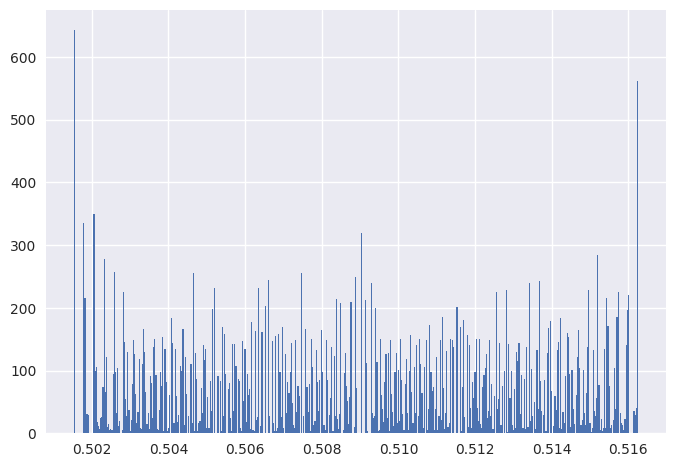

In [50]:
model1 = smf.ols(formula='YYY ~ rk ', data=df1).fit()
y_pred = model1.predict(df1[['rk']])
y_pred.hist(bins = 500)
model1.summary()


In [51]:
xx = OS[['factor','rk']]
yy = OS[['YYY']].copy()

y_pred = clf.predict(xx)

y_pred[y_pred>0] = 1
y_pred[y_pred<0] = 0

yy[yy>0] = 1
yy[yy<0] = 0

matrix = confusion_matrix(yy, y_pred)

FP = matrix.sum(axis=0) - np.diag(matrix)  
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = np.sum(matrix) - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(
    f'ACC:{ACC}',
    f'\nTPR:{TPR}',
    f'\nFPR:{FPR}',
)
pd.Series(y_pred).value_counts()


ACC:[0.50107454 0.50107454] 
TPR:[0.48907658 0.51317882] 
FPR:[0.48682118 0.51092342]


1.0    9054
0.0    8628
dtype: int64

In [ ]:
pd.Series(y_pred).value_counts()
# yy.value_counts()

1.0    12883
0.0     8611
dtype: int64

#### Hourly

<AxesSubplot:xlabel='openTime'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei


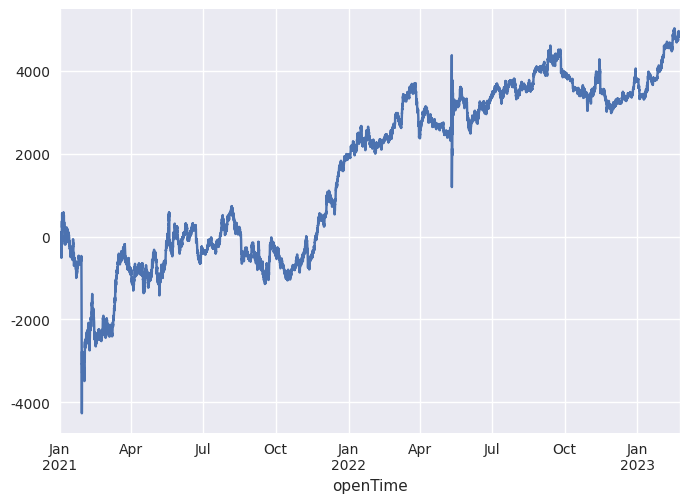

In [ ]:
select = cond.sum(axis = 1) * selected * 0.01
select = select.apply(lambda x:max(np.floor(x),3))


# rk = factor[cond].rank(axis = 1,ascending = True,method = 'dense')
rk = factor[cond].rank(axis = 1,pct = True,method = 'dense')

# long_signal = rk.copy()
# long_signal[:] = 0
# short_signal = long_signal.copy()

# long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
# short_signal[rk.le(select,axis = 0)] = -1 



rk = factor[cond].rank(axis = 1,pct=True,method = 'dense',ascending = '_Reverse' not in name)

long_signal = rk.add(-rk.mean(axis = 1),axis= 0)
long_signal[long_signal<0] = 0
short_signal = rk.add(-rk.mean(axis = 1),axis= 0)
short_signal[short_signal>0] = 0

long_result = fast_backtest(ret[subset],long_signal,fee = 0)#.sum(axis = 1)
short_result = fast_backtest(ret[subset],short_signal,fee = 0)#.sum(axis = 1)

result = ((long_result + short_result)/2).sum(axis = 1).loc[datetime(2021,1,1):]
result.cumsum().plot()

#### Test

In [ ]:
ret_t1 = ret[market_filter].shift(-1).loc[datetime(2021,1,1):].stack().reset_index().rename({0:'return(t+1)'},axis = 1)

## RankIC
rk = factor.rank(axis = 1,ascending = True,method = 'dense')
ff = rk.resample('D').last().loc[datetime(2021,1,1):]#.stack().reset_index().rename({0:'factor'},axis = 1)
ff = ff.stack().reset_index().rename({0:'factor'},axis = 1)
df = pd.merge(ff,ret_t1,on = ['openTime','symbol'])
Rank_IC = df.groupby('openTime').apply(lambda x: x.corr().iloc[1,0])
Rank_IR = Rank_IC.quantile(0.5)/Rank_IC.std()#.plot.bar()

IS_Rank_IC = Rank_IC.loc[datetime(2021,1,1):INSAMPLE_END_DATE]
IS_Rank_IR = IS_Rank_IC.quantile(0.5)/IS_Rank_IC.std()
IS_Rank_IC = IS_Rank_IC.quantile(0.5)
OS_Rank_IC = Rank_IC.loc[INSAMPLE_END_DATE:VALID_END_DATE]
OS_Rank_IR = OS_Rank_IC.quantile(0.5)/OS_Rank_IC.std()
OS_Rank_IC = OS_Rank_IC.quantile(0.5)
Rank_IC = Rank_IC.quantile(0.5)



In [ ]:
df[['factor','return(t+1)']].corr()

,factor,return(t+1)
factor,1.000000,0.002562
return(t+1),0.002562,1.000000


In [ ]:
data = (long_result + short_result) * factor
data = data[data!=0].loc[datetime(2021,1,1):]
# data = data.stack().reset_index().sort_values(['openTime',0]).rename({0:'factor'},axis = 1)
# data = pd.merge(data,result.reset_index().rename({0:'Return'},axis = 1).shift(-1),on = 'openTime')
data = data.values
data.sort(axis = 1)
data = pd.DataFrame(data,index = factor.loc[datetime(2021,1,1):].index)
data = data[data.columns[:6]]
data = pd.merge(data,result.reset_index().rename({0:'Return'},axis = 1),on = 'openTime').fillna(0).set_index('openTime')
data.Return = (data.Return/10**1 ).astype(int)#
data = data[data.Return<data.Return.quantile(0.99)]
data = data[data.Return>data.Return.quantile(0.01)]
# data = data[data.Return != 0]
data.Return = data.Return.shift(-1)
data = data.iloc[:-1]
data

,0,1,2,3,4,5,Return
openTime,,,,,,,
2021-01-01 00:00:00,-128.028311,-82.473161,-30.808563,18.560013,19.372797,328.754258,4.0
2021-01-01 01:00:00,-592.021568,-68.463150,28.076376,121.222840,376.021719,449.364640,0.0
2021-01-01 02:00:00,-124.689403,-31.017086,-27.968178,52.052652,167.066099,0.000000,0.0
2021-01-01 03:00:00,-46.717709,-20.811248,-16.159982,-9.228619,22.025097,554.686097,-11.0
2021-01-01 04:00:00,-74.817039,-22.709003,-4.638899,16.092062,57.370375,1809.678387,0.0
...,...,...,...,...,...,...,...
2023-02-23 02:00:00,-95.070560,-67.352527,-47.906508,251.231967,257.956934,1732.152642,0.0
2023-02-23 03:00:00,-269.168627,-188.544757,-166.136960,7.727623,17.766879,17.913911,0.0
2023-02-23 04:00:00,-39.828980,-11.081722,-1.800278,30.020273,131.872786,358.179112,0.0


In [ ]:
xx.stack().abs().describe()#.hist(bins = 500)

NameError: name 'xx' is not defined

<AxesSubplot:>

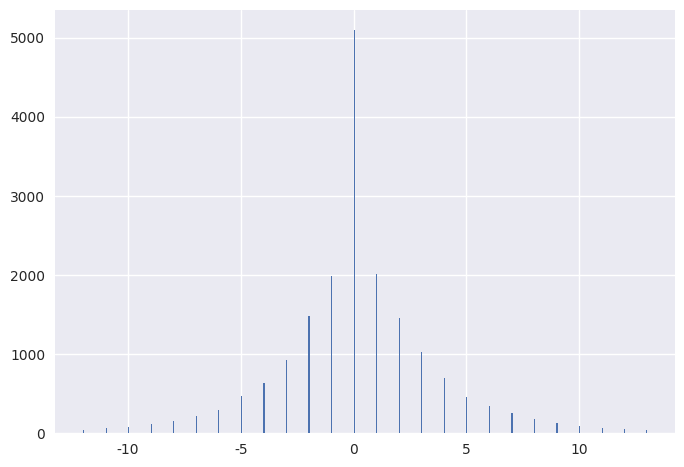

In [ ]:
data.Return.hist(bins = 500)

In [ ]:
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# clf = lgb.LGBMClassifier(max_depth = 6, num_leaves = 2,n_estimators = 10,subsample_for_bin = 500)
clf = DecisionTreeClassifier(max_depth = 4)


In [ ]:
IS = data.loc[datetime(2021,1,1):INSAMPLE_END].copy()#.corr()
IS = IS[IS.Return != 0]
IS[IS.Return.abs()<=1] = 0

IS[IS.Return>=1] = 1
IS[IS.Return<=-1] = -1
# IS = IS[IS.Return != 0]

OS = data.loc[INSAMPLE_END:].copy()#.corr()



xx = IS[data.columns[:6]]
yy = IS['Return']

clf = clf.fit(xx, yy)
y_pred = clf.predict(OS[data.columns[:6]])
threshold = 0
# y_pred[np.abs(y_pred)<=threshold] = 0
# y_pred[y_pred>threshold] = 1
# y_pred[y_pred<-threshold] = -1

yy = OS['Return'].copy()
yy[(yy.abs()<threshold)] = 0
yy[yy<-threshold] = -1
yy[yy>threshold] = 1
(yy-y_pred).abs().value_counts()

AttributeError: 'str' object has no attribute 'loc'

In [ ]:
IS.Return.value_counts()

 0    1488
 1    1362
-1    1293
Name: Return, dtype: int64

In [ ]:
y_pred = clf.predict(OS[data.columns[:6]])
pd.Series(y_pred).value_counts()

 0.0    14154
-1.0       67
 1.0       21
dtype: int64

In [ ]:
IS = data.loc[datetime(2021,1,1):INSAMPLE_END].copy()#.corr()
OS = data.loc[INSAMPLE_END:].copy()#.corr()
# IS['Ret(t+1)'] = (IS['Ret(t+1)']*10).astype(int)
# IS = IS[(IS>IS['Ret(t+1)'].quantile(0.01)) & (IS<IS['Ret(t+1)'].quantile(0.99))].dropna()
# IS = IS[(IS>IS['Factor'].quantile(0.01)) | (IS<IS['Factor'].quantile(0.99))]

xx = IS[data.columns[:6]]
yy = IS['Return']

x = sm.add_constant(xx)
# model = sm.OLS(yy, x).fit()
clf.fit(xx, yy)

print(model.params)

os_pred = model.predict(sm.add_constant(OS[data.columns[:6]]))
# os_pred = model.predict(OS['Factor'])

# os_pred.plot.hist(bins = 500,figsize = (12,4))

mse = (OS['Return']-os_pred).mean()
print(f'mse:{mse:.2f}')
# os_pred.describe()

NameError: name 'model' is not defined

<AxesSubplot:xlabel='openTime'>

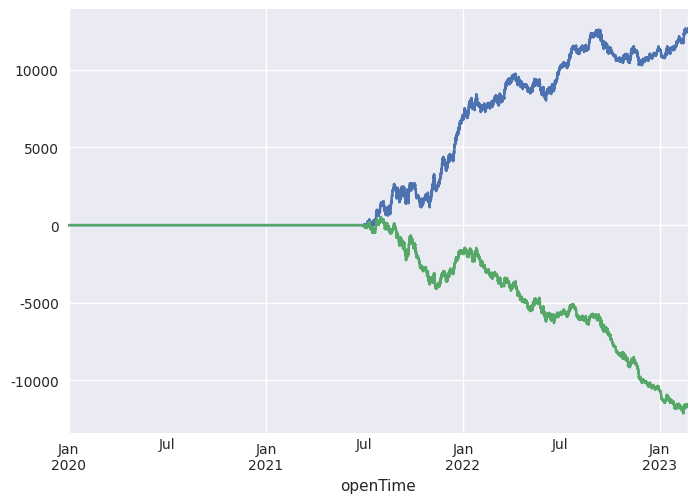

In [ ]:
signal1 = y_pred.copy()
signal1[signal1<0] = 0

long_signal[rk.gt(cond.sum(axis = 1) - select,axis = 0)] = 1 
short_signal[rk.le(select,axis = 0)] = -1 

signal = long_signal + short_signal# * -1
signal = signal.loc[OS.index]#.multiply(signal1,axis = 0)

result1 = fast_backtest(ret[subset],signal,fee = 4)#.sum(axis = 1)
result1.sum(axis = 1).cumsum().plot()

signal = signal.loc[OS.index].multiply(signal1,axis = 0)
result1 = fast_backtest(ret[subset],signal,fee = 4)#.sum(axis = 1)
result1.sum(axis = 1).cumsum().plot()

In [ ]:
signal1

array([ 0,  0, -1, ...,  1,  0,  0])

In [ ]:
outsample = metrics.iloc[start:]
xx = outsample['Insample Long Beta'].to_list() + outsample['Insample Short Beta'].to_list()
yy = outsample['Long Outsample Fitness'].to_list() + outsample['Short Outsample Fitness'].to_list()

y_pred = model.predict(xx)
y_pred[y_pred>=0] = 1
y_pred[y_pred<0] = -1

yy = np.array(yy)
yy[yy>=0] = 1
yy[yy<0] = -1

matrix = confusion_matrix(yy, y_pred)

FP = matrix.sum(axis=0) - np.diag(matrix)  
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = np.sum(matrix) - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC